In [1]:
import numpy as np
import matplotlib.pylab as plt
from pulp import LpProblem, LpMinimize, LpMaximize, LpVariable, LpInteger, LpBinary, LpContinuous, lpSum, LpStatus, value

### Question 1
Using the graphical method solve the mathematical programming and identify redundant constraints

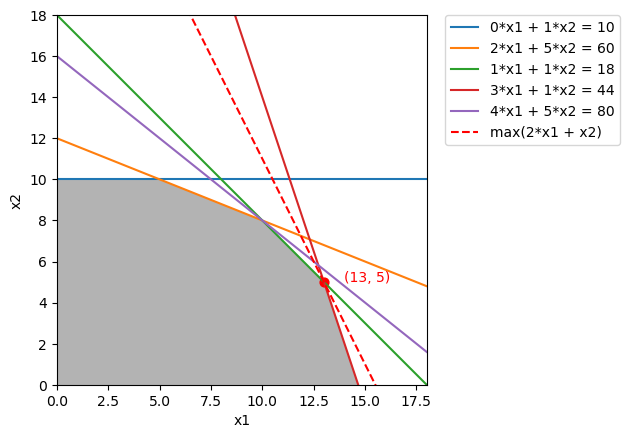

In [2]:
A = [[0, 1], [2, 5], [1, 1], [3, 1], [4, 5], [-1, 0], [0, -1]]
B = [10, 60, 18, 44, 80, 0, 0]

# plot feasible region
d = np.linspace(0, 18, 1000)
x1, x2 = np.meshgrid(d, d)
plt.imshow(eval(f"({'&'.join([f'({a[0]}*x1 + {a[1]}*x2 <= {b})' for a, b in zip(A, B)])}).astype(int)"),
           extent=(x1.min(), x1.max(), x2.min(), x2.max()), origin="lower", cmap="Greys", alpha=0.3)

# plot constraints
x1 = np.linspace(0, 18, 1000)
for a, b in zip(A[:-2], B[:-2]):
    x2 = (b - a[0] * x1) / a[1]
    plt.plot(x1, x2, label=f'{a[0]}*x1 + {a[1]}*x2 = {b}')

# plot objective function
x2 = 31 - 2 * x1
plt.plot(x1, x2, label=f'max(2*x1 + x2)', color="red", linestyle='dashed')
plt.scatter([13, ], [5, ], marker="o", color="red", s=40)
plt.annotate("(13, 5)", (13, 5), xytext=(14, 5), color="red")

# set xy axis limit and generate legend
plt.xlim(0, 18)
plt.ylim(0, 18)
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### Question 2
Use piecewise-linearization to approximate a non-linear optimisation

#### 2.1 Display the original function and approximated piecewise function

In [3]:
def objective_func(x):
    return 1 * np.exp(x) + 3 * np.power(x, 2) - 4 * np.power(x, 5) - 1

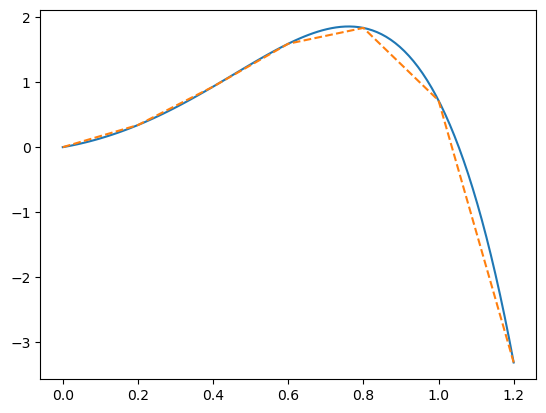

In [4]:
x = np.linspace(0, 1.2, 100)
y = objective_func(x)

break_x = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
break_y = objective_func(break_x)

plt.plot(x, y)
plt.plot(break_x, break_y, linestyle="dashed")

#### 2.2 Solve the piecewise-linearized formulation

In [5]:
# create minimising problem
prob = LpProblem("Piecewise-Approximation", LpMaximize)

# create variables
num_t = len(break_x)
num_y = num_t - 1
vars_t = [LpVariable(f"t_{i}", lowBound=0, cat=LpContinuous) for i in range(num_t)]
vars_y = [LpVariable(f"y_{i}", cat=LpBinary) for i in range(num_y)]

# The objective function is added to 'prob' first
prob += lpSum([break_y[i] * vars_t[i] for i in range(num_t)])

# add constraints - only adjacent two t_i can be non-zero
prob += vars_t[0] <= vars_y[0]

for i in range(1, num_y):
    prob += vars_t[i] <= vars_y[i - 1] + vars_y[i]

prob += vars_t[-1] <= vars_y[-1]

# add constraints - sum of y and sum of z both equal to 1
prob += lpSum([vars_t[i] for i in range(num_t)]) == 1
prob += lpSum([vars_y[i] for i in range(num_y)]) == 1

# solve
prob.solve()

# We request the status of problem to check if it is properly solved
# The status can be “Not Solved”, “Infeasible”, “Unbounded”, “Undefined” or “Optimal”
print("Status:", LpStatus[prob.status])

# output
x = sum([break_x[i] * vars_t[i].value() for i in range(num_t)])
print(f"The optimal value of transformed decision variables t_i: {[vars_t[i].value() for i in range(num_t)]}")
print(f"The optimal value of the original decision variable x: {x}")
print(f"The maximum of approximated objective function: {value(prob.objective)}")



Status: Optimal
The optimal value of transformed decision variables t_i: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
The optimal value of the original decision variable x: 0.8
The maximum of approximated objective function: 1.834820928492468


### Question 3: Transportation Problem

In [6]:
authorities = ['LA1', 'LA2', 'LA3']
factories = ['F1', 'F2']

c = {'F1': {'LA1': 800, 'LA2': 700, 'LA3': 400},
     'F2': {'LA1': 600, 'LA2': 800, 'LA3': 500}}

prob = LpProblem('Transportation-Problem', LpMinimize)

x = LpVariable.dicts('x', [(i, j) for i in factories for j in authorities], lowBound=0, cat=LpInteger)

prob += lpSum(x[(i, j)] * c[i][j] for i in factories for j in authorities)

#Production capacity constraints
for i in factories:
    prob += (lpSum(x[(i, j)] for j in authorities)) <= 50

#Fixed amount of buses per authority per week
for j in authorities:
    prob += (lpSum(x[(i, j)] for i in factories)) == 20

# solve problem
prob.solve()
print('Status', LpStatus[prob.status])

# output results
for v in prob.variables():
    if v.varValue > 0:
        print(v.name, '=', v.varValue)

print('Total costs:', (value(prob.objective)))

Status Optimal
x_('F1',_'LA2') = 20
x_('F1',_'LA3') = 20
x_('F2',_'LA1') = 20
Total costs: 34000


### Question 4 Bus Driver Scheduling Problem

#### Simplified Formulation

- The key to formulate this problem as a LP problem is to define the decision variable as <b>the number of employees beginning to work at time t </b>.
- We note that for this particular case, there is a constant demand for blocks of 4 hours, which is exactly half a shift.
- Therefore, in an optimal workforce schedule, the drivers will begin their shifts always at the beginning of a 4-hour block, i.e. t=0,4,8,12,16 or 20.

In [7]:
#Minimum demand vector for t=0,4,8,12,16,20
b = [40, 80, 100, 70, 120, 40]

# we create indexes for decision variables - "D0" to
drivers = ['D' + str(i * 4) for i in range(len(b))]

prob = LpProblem('Driver-Scheduling', LpMinimize)
x = LpVariable.dicts('x', [i for i in drivers], lowBound=0, cat=LpInteger)

prob += lpSum(x[(i)] for i in drivers)

prob += x['D20'] + x['D0'] >= b[0]
prob += x['D0'] + x['D4'] >= b[1]
prob += x['D4'] + x['D8'] >= b[2]
prob += x['D8'] + x['D12'] >= b[3]
prob += x['D12'] + x['D16'] >= b[4]
prob += x['D16'] + x['D20'] >= b[5]

prob.solve()

for v in prob.variables():
    if v.varValue > 0:
        print(v.name, '=', v.varValue)

print('Total drivers:', (value(prob.objective)))

x_D0 = 40
x_D12 = 80
x_D16 = 40
x_D4 = 100
Total drivers: 260


#### Formulation 2: general 24-hour shift scheduling
- In last formulation, we took advantage of the fact that demand for workers was constant in blocks of 4 hours. This simplified the problem.
- However, in any other case, we can solve the general scheduling problem by imposing a constraint for each hour (total of 24 constraints).

In [8]:
#We use the entire minimum demand vector
b = [40, 40, 40, 40, 80, 80, 80, 80, 100, 100, 100, 100,
     70, 70, 70, 70, 120, 120, 120, 120, 40, 40, 40, 40]

#shift duration: 8 hours
shift = 8

#A list that contains each hour
hour = [i for i in range(24)]

drivers = ['D' + str(i) for i in range(len(b))]

prob = LpProblem('Driver-Scheduling', LpMinimize)
x = LpVariable.dicts('x', [i for i in drivers], lowBound=0, cat=LpInteger)
prob += lpSum(x[(i)] for i in drivers)

for i in range(24):
    prob += (lpSum(x['D' + str(hour[i - j])] for j in range(shift))) >= b[i]

prob.solve()
print('Status', LpStatus[prob.status])

for v in prob.variables():
    if v.varValue > 0:
        print(v.name, '=', v.varValue)

print('Total drivers:', (value(prob.objective)))

Status Optimal
x_D10 = 40
x_D12 = 10
x_D13 = 20
x_D16 = 50
x_D18 = 40
x_D2 = 40
x_D4 = 40
x_D5 = 20
Total drivers: 260


We obtain a different schedule in this case, but with the same number of total workers (objective function).

### Question 5 Transshipment Problem

In [9]:
# set of manufactures, retailers and warehouses
manufactures = ['M1', 'M2', 'M3']
retailers = ['R1', 'R2', 'R3']
warehouses = ['W1', 'W2']

# cost matrix from warehouses to retailers
c_w2r = {'W1': {'R1': 100, 'R2': 150, 'R3': 200},
         'W2': {'R1': 50, 'R2': 150, 'R3': 100}}

c_m2w = {"M1": {"W1": 100, "W2": 200},
         "M2": {"W1": 50, "W2": 250},
         "M3": {"W1": 250, "W2": 100}}

# production capacity, warehouse storage capacity and retailer demand
p = {'M1': 1000, 'M2': 2500, 'M3': 1500}
s = {'W1': 3000, 'W2': 3000}
d = {'R1': 500, 'R2': 1600, 'R3': 2900}

prob = LpProblem('Transshipment-Problem', LpMinimize)

# create decision variables
x = LpVariable.dicts('x', [(i, j) for i in manufactures for j in warehouses], lowBound=0, cat=LpInteger)
y = LpVariable.dicts('y', [(j, k) for j in warehouses for k in retailers], lowBound=0, cat=LpInteger)

# set objective
prob += lpSum(x[(i, j)] * c_m2w[i][j] for i in manufactures for j in warehouses) + lpSum(
    y[(j, k)] * c_w2r[j][k] for j in warehouses for k in retailers)

# Production capacity constraints
for i in manufactures:
    prob += (lpSum(x[(i, j)] for j in warehouses)) <= p[i]

# Warehouse storage capacity constraints
for j in warehouses:
    prob += (lpSum(x[(i, j)] for i in manufactures)) <= s[j]

# Retailer demand constraints
for k in retailers:
    prob += (lpSum(y[(j, k)] for j in warehouses)) >= d[k]

# flow conservation at warehouses
for j in warehouses:
    prob += (lpSum(x[(i, j)] for i in manufactures)) == (lpSum(y[(j, k)] for k in retailers))

# solve problem
prob.solve()
print('Status', LpStatus[prob.status])

# output results
for i in manufactures:
    for j in warehouses:
        print(f"{x[i, j].varValue} units of commodities are shipped from manufacture {i} to warehouse {j}")

# output results
for j in warehouses:
    for k in retailers:
        print(f"{y[j, k].varValue} units of commodities are shipped from manufacture {i} to warehouse {j}")

print('Total costs:', (value(prob.objective)))

Status Optimal
500 units of commodities are shipped from manufacture M1 to warehouse W1
500 units of commodities are shipped from manufacture M1 to warehouse W2
2500 units of commodities are shipped from manufacture M2 to warehouse W1
0 units of commodities are shipped from manufacture M2 to warehouse W2
0 units of commodities are shipped from manufacture M3 to warehouse W1
1500 units of commodities are shipped from manufacture M3 to warehouse W2
500 units of commodities are shipped from manufacture M3 to warehouse W1
1600 units of commodities are shipped from manufacture M3 to warehouse W1
900 units of commodities are shipped from manufacture M3 to warehouse W1
0 units of commodities are shipped from manufacture M3 to warehouse W2
0 units of commodities are shipped from manufacture M3 to warehouse W2
2000 units of commodities are shipped from manufacture M3 to warehouse W2
Total costs: 1095000


### Question 6 Location Problem

In [10]:
# set of candidate locations and retailers
retailers = [0, 1, 2, 3]  # We number 4 retailers from 0 to 3
locations = [0, 1, 2]  # We number 3 candidate locations from 0 to 2

# operational cost matrix - row represents retailers while column represents locations
oper_cost = [[50, 12, 37],
             [30, 40, 38],
             [42, 52, 48],
             [53, 38, 11], ]

# construction cost
cons_cost = [50, 60, 45]

prob = LpProblem('Location-Problem', LpMinimize)

# create decision variables
x = LpVariable.dicts('x', [(i, j) for i in retailers for j in locations], cat=LpBinary)
y = LpVariable.dicts('y', locations, cat=LpBinary)

# set objective
prob += lpSum(x[(i, j)] * oper_cost[i][j] for i in retailers for j in locations) + lpSum(
    y[j] * cons_cost[j] for j in locations)

# Constraints - each retailer is only assigned to one warehouse
for i in retailers:
    prob += (lpSum(x[(i, j)] for j in locations)) == 1

# Constraints - warehouse capacity
for j in locations:
    prob += (lpSum(x[(i, j)] for i in retailers)) <= 3

# Constraints - only when the warehouse is constructed can a retailer be served by it
for j in locations:
    for i in retailers:
        prob += x[i, j] <= y[j]

# solve problem
prob.solve()
print('Status', LpStatus[prob.status])

# output results
for j in locations:
    if y[j].varValue > 0:
        print(f"A warehouse is constructed at location {j}")

for i in retailers:
    for j in locations:
        if x[i, j].varValue > 0:
            print(f"Retailer {i} is assigned to warehouse constructed at location {j}")

print('Total costs:', (value(prob.objective)))

Status Optimal
A warehouse is constructed at location 1
A warehouse is constructed at location 2
Retailer 0 is assigned to warehouse constructed at location 1
Retailer 1 is assigned to warehouse constructed at location 2
Retailer 2 is assigned to warehouse constructed at location 2
Retailer 3 is assigned to warehouse constructed at location 2
Total costs: 214


### Question 7 (Optional) Discount Quantity Problem

In [11]:
# create variables
t1 = LpVariable("t1", lowBound=0, cat=LpInteger)
t2 = LpVariable("t2", lowBound=0, cat=LpInteger)
xa = LpVariable("xa", lowBound=0, cat=LpInteger)
xb = LpVariable("xb", lowBound=0, cat=LpInteger)

prob = LpProblem('Discount-Quantity-Problem', LpMinimize)

# set objective function
prob += t1 + t2

# set constraints
prob += t1 <= 100 * xa
prob += t1 <= 90 * xa + 3000
prob += t2 <= 110 * xb
prob += t2 <= 80 * xb + 9000
prob += xa + xb == 1000

# solve problem
prob.solve()
print('Status', LpStatus[prob.status])

print(f"the optimal shipping combination is shipping {xa.varValue} by method A and {xb.varValue} by method B")

Status Optimal
the optimal shipping combination is shipping 0 by method A and 1000 by method B
